# Flight Fare Prediction

In [91]:
#Importing required libraries 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV , train_test_split

In [92]:
train_data = pd.read_excel(r"Data_Train.xlsx")

In [93]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [94]:
train_data.shape

(10683, 11)

In [95]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Only target variable is of type int. Rest all are objects

In [96]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [97]:
#Dropping Missing Values

train_data.dropna(inplace = True)

# EDA

Handling Date/ Time object columns

Converting string values in columns "Date_of_Journey", "Dep_Time" and"Arrival_Time" to Datetime


In [98]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

# Drop Date_of_Journey column as it has been converted into integers.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [99]:
# Departure time is when a plane leaves the gate. 

# Extracting Hours
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [100]:
# Arrival time is when the plane pulls up to the gate.

# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [101]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [102]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [103]:
# Adding duration_hours and duration_mins list to train_data dataframe

train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [104]:
# Drp Duration column
train_data.drop(["Duration"], axis = 1, inplace = True)

In [105]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


Handling Categorical Data

In [106]:
train_data.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins'],
      dtype='object')

In [107]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [108]:
train_data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [109]:
train_data['Airline'].replace('Multiple carriers Premium economy','Multiple carriers',inplace=True)
train_data['Airline'].replace('Vistara Premium economy','Vistara',inplace=True)
train_data['Airline'].replace('Jet Airways Business','Jet Airways',inplace=True)

In [110]:
train_data = train_data[train_data.Airline != 'Trujet']

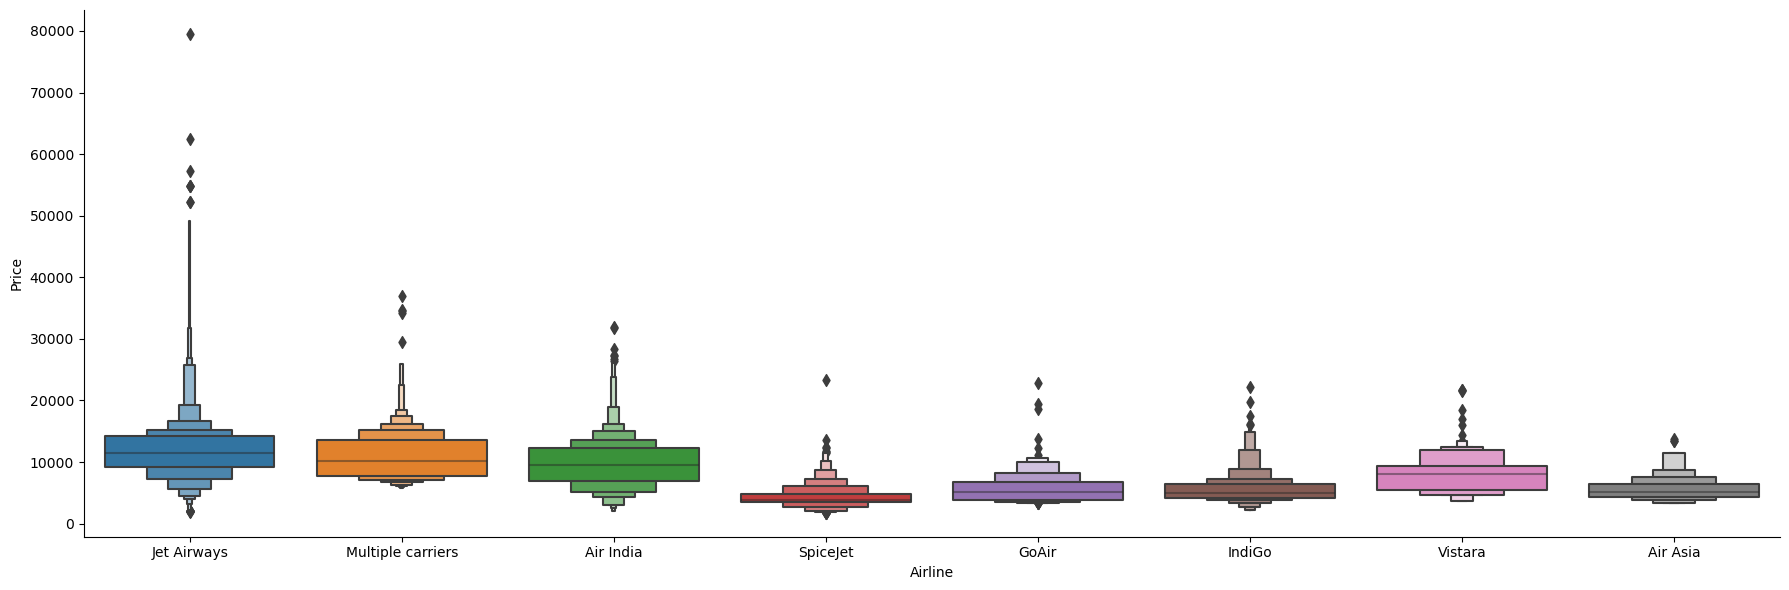

In [111]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [112]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Vistara
0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


In [113]:

train_data["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       696
Chennai      381
Name: Source, dtype: int64

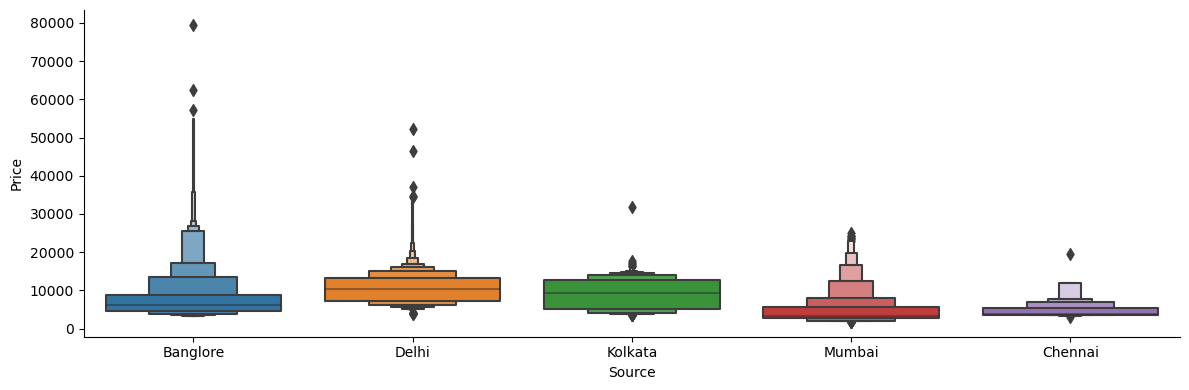

In [114]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [115]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = train_data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [116]:
train_data["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     696
Kolkata       381
Name: Destination, dtype: int64

In [117]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [118]:
train_data["Route"]

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10681, dtype: object

In [119]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [120]:
train_data["Total_Stops"].value_counts()

1 stop      5624
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [121]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [122]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [123]:
data_train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,...,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,...,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,...,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,...,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,...,0,0,0,0,0,0,0,0,0,1


In [124]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [125]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1


In [126]:
data_train.shape

(10681, 26)

Test Data

In [127]:
test_data = pd.read_excel(r"Test_set.xlsx")

In [128]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [129]:
# Preprocessing

print("Test data Info")
print("-"*75)
print(test_data.info())

print()
print()

print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data
test_data['Airline'].replace('Multiple carriers Premium economy','Multiple carriers',inplace=True)
test_data['Airline'].replace('Vistara Premium economy','Vistara',inplace=True)
test_data['Airline'].replace('Jet Airways Business','Jet Airways',inplace=True)
print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)



Test data Info
---------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB
None


Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time         

In [130]:
data_test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,...,Vistara,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,...,0,0,0,0,0,0,1,0,0,0


In [131]:
data_test.columns

Index(['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min',
       'Arrival_hour', 'Arrival_min', 'Duration_hours', 'Duration_mins',
       'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Multiple carriers',
       'SpiceJet', 'Vistara', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai',
       'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi'],
      dtype='object')

In [132]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Vistara', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

Feature Selection

In [133]:
data_train.shape

(10681, 26)

In [134]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Vistara', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

In [135]:
X = data_train.drop('Price', axis = 1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,0,0,1


In [136]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

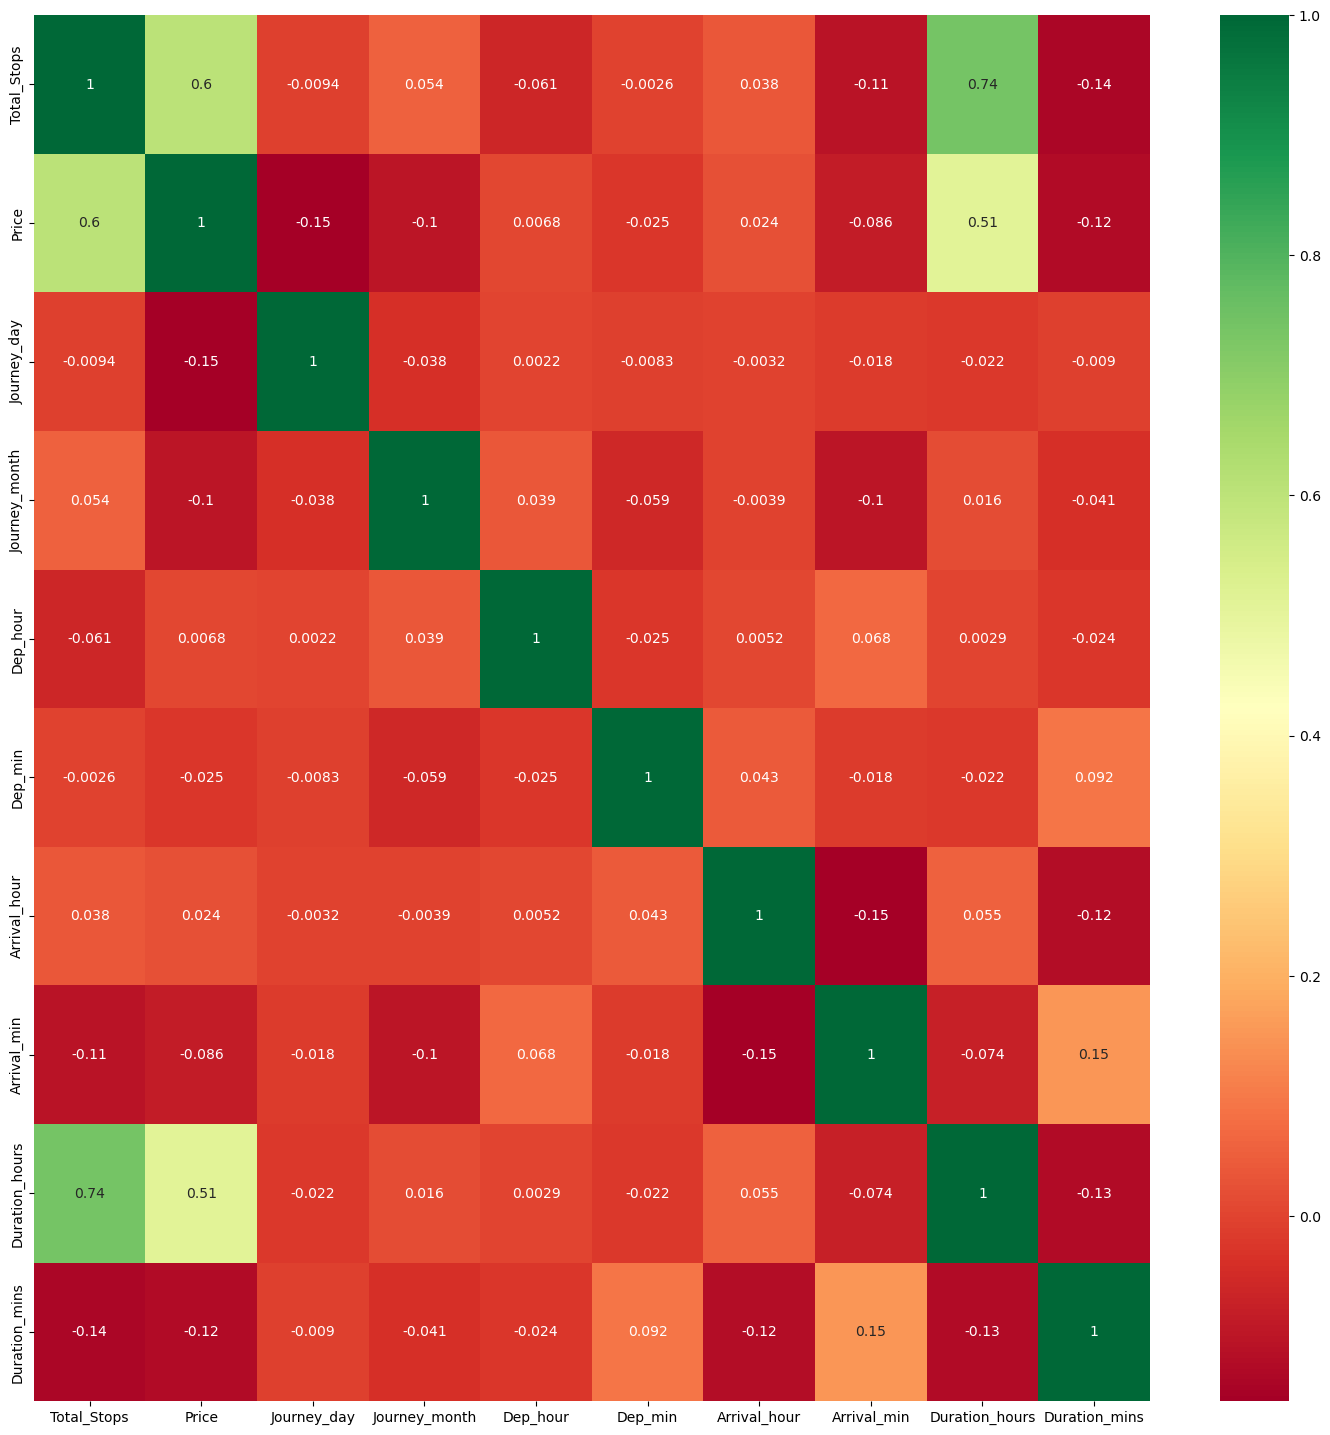

In [137]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [138]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [139]:
print(selection.feature_importances_)

[0.20054649 0.16187665 0.05759373 0.0276851  0.02953534 0.02896791
 0.02050735 0.15030086 0.02125141 0.01342872 0.00191005 0.01321796
 0.15189212 0.0212729  0.00273748 0.00536414 0.0004922  0.01435494
 0.00358149 0.00845706 0.0095988  0.01854428 0.00618173 0.00039514
 0.03030615]


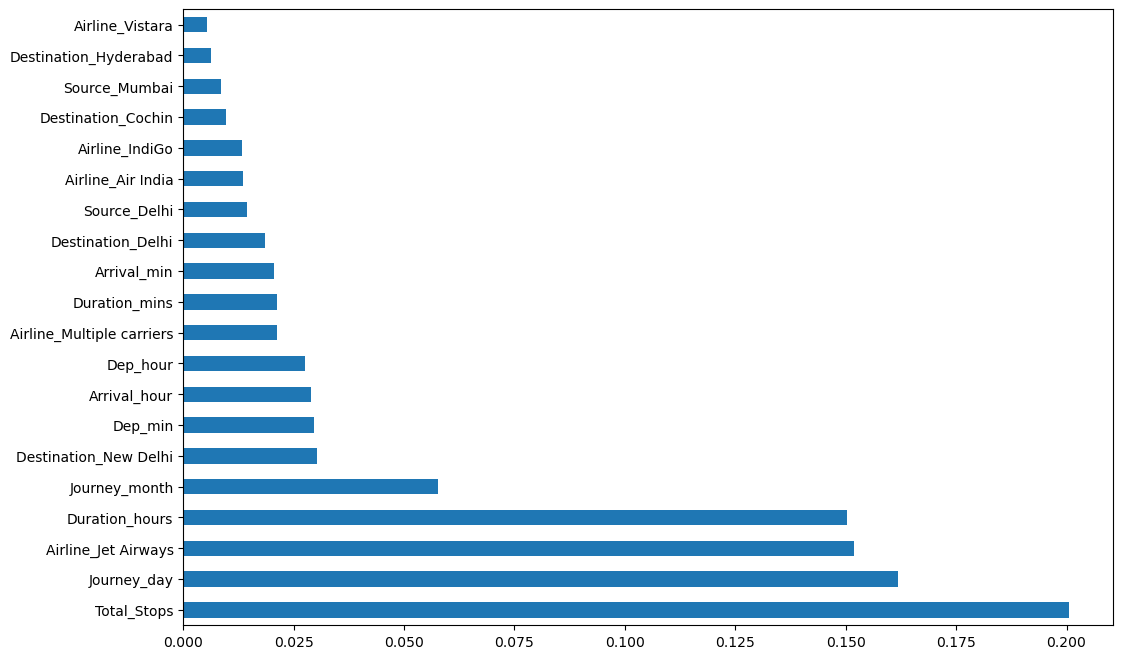

In [140]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

Fitting model using Random Forest

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Model Building

In [142]:
##create model
lr = LinearRegression()
xgb = XGBRegressor()
rfr = RandomForestRegressor()
dt = DecisionTreeRegressor()

In [143]:
print(lr.fit(X_train , y_train))
print(xgb.fit(X_train , y_train))
print(rfr.fit(X_train , y_train))
print(dt.fit(X_train , y_train))

LinearRegression()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
RandomForestRegressor()
DecisionTreeRegressor()


In [144]:
#train acc

print(r2_score(lr.predict(X_train) , y_train))
print(r2_score(xgb.predict(X_train) , y_train))
print(r2_score(rfr.predict(X_train) , y_train))
print(r2_score(dt.predict(X_train) , y_train))

0.2323620025466292
0.9316914403905064
0.9488077453033195
0.9720218815972159


Random Forest

In [145]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [146]:
y_pred = reg_rf.predict(X_test)

In [147]:
reg_rf.score(X_train, y_train)

0.9535313463184328

In [148]:
reg_rf.score(X_test, y_test)

0.7828266488608384

C:\Users\DELL\AppData\Local\Temp\ipykernel_16184\3453123835.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


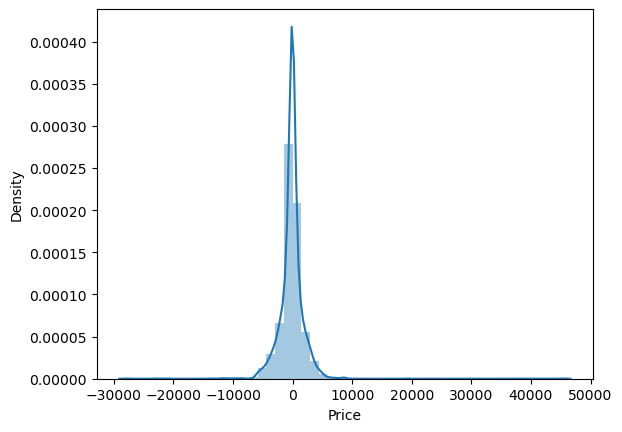

In [149]:
sns.distplot(y_test-y_pred)
plt.show()

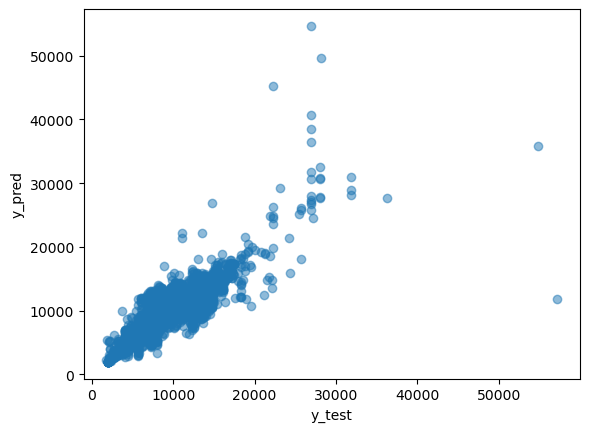

In [150]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [151]:
from sklearn import metrics

In [152]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1185.8763605137624
MSE: 4571060.867538728
RMSE: 2138.0039446967185


In [153]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [154]:
metrics.r2_score(y_test, y_pred)

0.7828266488608384

Hyperparameter Tuning


In [155]:
from sklearn.model_selection import RandomizedSearchCV

In [157]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 900, num = 12)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 7]

In [158]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [159]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [160]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=681; total time=  30.9s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=681; total time=  30.8s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=681; total time=  31.3s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=681; total time=  31.9s
[CV] END max_depth=25, min_samples_leaf=2, min_samples_split=5, n_estimators=681; total time=  31.2s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=754; total time=  19.9s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=754; total time=  11.3s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=754; total time=  12.4s
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=754; total time=  11.9s
[CV] END max_depth=15, min

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'min_samples_leaf': [1, 2, 5, 7],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 172, 245, 318,
                                                         390, 463, 536, 609,
                                                         681, 754, 827, 900]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [254]:
rf_random.best_params_

{'n_estimators': 918,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 30}

In [255]:
prediction = rf_random.predict(X_test)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11552\375150797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


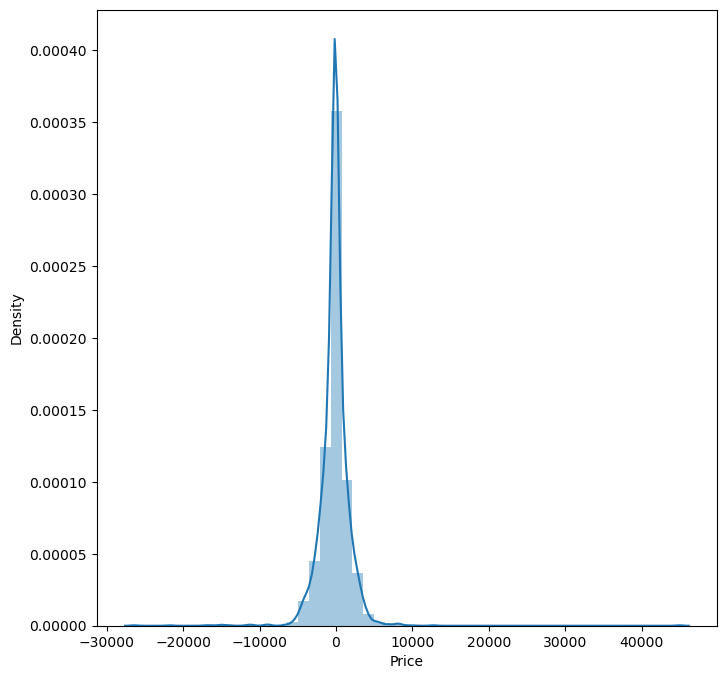

In [256]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

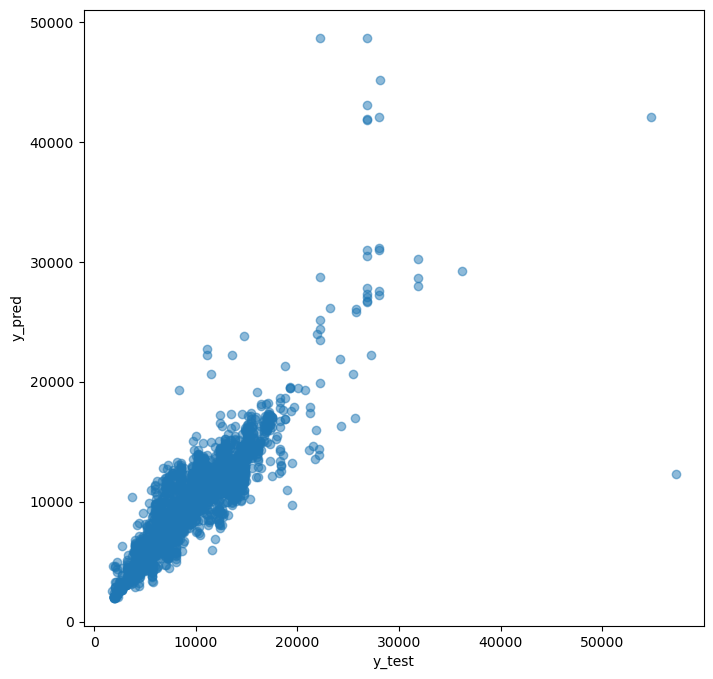

In [257]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [258]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1153.3276485705062
MSE: 4200158.345502623
RMSE: 2049.4287851746944


In [259]:
metrics.r2_score(y_test, prediction)

0.800448410196062

In [260]:
rf_p = {
    
    "min_samples_split": list(range(2,11)),
    "min_samples_leaf" : list(range(1,10)),
    "max_depth":list(range(1,200)),
    "n_estimators": list(range(1,500))
}

In [261]:
rscv = RandomizedSearchCV(reg_rf, param_distributions=rf_p , cv =10 , n_iter=10  ,n_jobs = -1 , verbose = 10)

In [262]:
rscv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   verbose=10)

In [263]:
rscv.best_params_

{'n_estimators': 220,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 151}

In [264]:
p = rscv.predict(X_test)

In [265]:
print('MAE:', metrics.mean_absolute_error(y_test, p))
print('MSE:', metrics.mean_squared_error(y_test, p))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, p)))

MAE: 1153.3728616140868
MSE: 4180252.9357037526
RMSE: 2044.5666865386788


In [266]:
metrics.r2_score(y_test, p)

0.8013941260106376

In [267]:
rscv.best_estimator_

RandomForestRegressor(max_depth=151, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=220)

In [268]:
rfr =RandomForestRegressor(bootstrap=True, criterion='absolute_error', max_depth=151,
                      max_leaf_nodes=None,
                      min_impurity_decrease=0.0,
                      min_samples_leaf=2, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=220,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [269]:
rfr.fit(X_train,y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=151,
                      min_samples_leaf=2, min_samples_split=3,
                      n_estimators=220)

In [89]:
predict_rfr = rfr.predict(X_test)

In [90]:
print('MAE:', metrics.mean_absolute_error(y_test, predict_rfr))
print('MSE:', metrics.mean_squared_error(y_test, predict_rfr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict_rfr)))

NameError: name 'metrics' is not defined

In [88]:
metrics.r2_score(y_test, predict_rfr)

NameError: name 'metrics' is not defined

# Save the model to reuse it again

In [79]:
#Saving the model in a pickle file
import pickle
file = open('fare_rf.pkl', 'wb')
pickle.dump(rfr , file)

In [274]:
model = open('fare_rf.pkl','rb')
forest = pickle.load(model)

In [275]:
y_prediction = forest.predict(X_test)

In [276]:
metrics.r2_score(y_test, y_prediction)

0.8131275283005326

In [88]:
#from pyngrok import ngrok
 
#public_url = ngrok.connect('8501')
#public_url

In [85]:
pip install session-info


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 63.5/63.5 kB 845.5 kB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8073 sha256=bd5ad633ed647249a51be8a1382742480bcc1f2cd77f272a856b0c12e4053890
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\10\95\8e\0027616beb8c496d40470a655c3fbb5699aec17e5004258617
Successfully built session-info
Note: you may need to restart the kernel to use updated packages.


In [86]:
import session_info
session_info.show()